In [1]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd

import nibabel as nib
from nilearn import datasets, surface, plotting, image
from nilearn.surface import vol_to_surf
from nilearn.image import resample_to_img
from nilearn.input_data import NiftiMasker
from nilearn.plotting import (
    plot_surf_roi,
    view_surf,
    plot_stat_map,
    plot_surf_contours
)

from statsmodels.stats.multitest import multipletests

sys.path.append('../general_functions/')
from plotting_brains_surfplot import (
    map_values_to_atlas,
    calc_alpha,
    make_translucent_map,
    Plot,
    check_surf
)

fsaverage = datasets.fetch_surf_fsaverage()


/Users/f004p59/.local/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
/Users/f004p59/.local/lib/python3.7/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
from surfplot.surf import plot_surf
#from surfplot import Plot -- importing modified Class
from brainspace.datasets import load_parcellation
from brainspace.mesh.mesh_io import read_surface
from neuromaps.datasets import fetch_fslr

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
atlas_surf = load_parcellation('schaefer', 100, join = True)

#DEFINING THE COLOR MAPS
from matplotlib.colors import LinearSegmentedColormap


basic_cols=['k', 'k', 'k']
black_cmap=LinearSegmentedColormap.from_list('mycmap', basic_cols)

basic_cols=['blue', 'blue', 'blue']
blue_cmap=LinearSegmentedColormap.from_list('mycmap', basic_cols)

basic_cols=['brown', 'brown', 'brown']
brown_cmap=LinearSegmentedColormap.from_list('mycmap', basic_cols)




# Step 1: want to get the regions that show the non-filtered effects on all dimensions that we have pre-defined

In [3]:
#Criterion 1
L2_more_than_0 = pd.read_csv('model_outputs/Lucy_L2_event1_vs_L1_t_test_results.csv')
#Criterion 2
L1_slope_pos = pd.read_csv("model_outputs/across_node_estimate_p_r_event_lucy_L1.csv")
#Criterion 3
L1_slope_more_L2 = pd.read_csv("model_outputs/across_node_estimate_p_r_event_listen_lucy_L1.csv")
#Criterion 4
L1_steve_slope = pd.read_csv("model_outputs/across_node_estimate_p_r_event_steve_L1.csv")
L2_steve_slope = pd.read_csv("model_outputs/across_node_estimate_p_r_event_steve_L2.csv")

merged_df = (
    L2_more_than_0[['node', 't_statistic', 'p_value']].rename(columns={'t_statistic': 'L2_more_than_0_t', 'p_value': 'L2_more_than_0_p'})
    .merge(L1_slope_pos[['node', 'event_estimate', 'event_p_value']], on='node', suffixes=('', '_L1_slope_pos'))
    .merge(L1_slope_more_L2[['node', 'event_listenL1_greater_estimate', 'event_listenL1_greater_p_value']], on='node')
    .merge(L1_steve_slope[['node', 'event_estimate', 'event_p_value']], on='node', suffixes=('', '_L1_steve_slope'))
    .merge(L2_steve_slope[['node', 'event_estimate', 'event_p_value']], on='node', suffixes=('', '_L2_steve_slope'))
)

# Apply criteria with correct checks for non-significant p-values
selected_nodes = merged_df[
    (merged_df['L2_more_than_0_t'] > 0) &   # L2_more_than_0 positive 
    (merged_df['event_estimate'] > 0) &  # L1_slope_pos positive 
    (merged_df['event_listenL1_greater_estimate'] > 0) &  # L1_slope_more_L2 positive 
    ((merged_df['event_estimate_L1_steve_slope'] < 0) | (merged_df['event_p_value_L1_steve_slope'] >= 0.05)) &  # L1_steve_slope negative or not significantly positive
    ((merged_df['event_estimate_L2_steve_slope'] < 0) | (merged_df['event_p_value_L2_steve_slope'] >= 0.05))  # L2_steve_slope negative or not significantly positive
]


print("Nodes meeting desired directionality and significance criteria:")
print(list(selected_nodes['node']))
print(len(selected_nodes[['node']]))

Nodes meeting desired directionality and significance criteria:
['3', '5', '6', '7', '9', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '53', '55', '56', '58', '59', '60', '61', '62', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', 'hippocampus_L', 'hippocampus_R']
90


## Step 2: Now going to want to contour (in black) the ones that are FDR corrected for our main analysis! 

In [4]:
# Specify the bad ROIs to exclude
bad_ROIs = [30, 31, 32, 78, 79]
threshold = 0.05

def fdr_correction_with_exclusions(df, p_value_col, roi_col='node', bad_rois=bad_ROIs, threshold=threshold):
    q_values = np.full(len(df), np.nan)
    
    # Filter out rows with bad ROIs and extract p-values
    valid_df = df[~df[roi_col].isin(bad_rois)]
    p_vals = valid_df[p_value_col].values

    _, corrected_p_vals, _, _ = multipletests(p_vals, alpha=threshold, method='fdr_bh')
    
    # Assigning corrected p-values back, preserving the order and setting NaN for excluded ROIs
    q_values[~df[roi_col].isin(bad_rois)] = corrected_p_vals
    return q_values

# Apply FDR correction to each analysis
L2_more_than_0['q_value'] = fdr_correction_with_exclusions(L2_more_than_0, 'p_value')
L1_slope_pos['q_value'] = fdr_correction_with_exclusions(L1_slope_pos, 'event_p_value')
L1_slope_more_L2['q_value'] = fdr_correction_with_exclusions(L1_slope_more_L2, 'event_listenL1_greater_p_value')
L1_steve_slope['q_value'] = fdr_correction_with_exclusions(L1_steve_slope, 'event_p_value')
L2_steve_slope['q_value'] = fdr_correction_with_exclusions(L2_steve_slope, 'event_p_value')

merged_df = (
    L2_more_than_0[['node', 't_statistic', 'q_value']].rename(columns={'t_statistic': 'L2_more_than_0_t', 'q_value': 'L2_more_than_0_q'})
    .merge(L1_slope_pos[['node', 'event_estimate', 'q_value']].rename(columns={'event_estimate': 'event_estimate_L1_slope_pos', 'q_value': 'q_value_L1_slope_pos'}), on='node')
    .merge(L1_slope_more_L2[['node', 'event_listenL1_greater_estimate', 'q_value']].rename(columns={'event_listenL1_greater_estimate': 'event_listenL1_greater_estimate', 'q_value': 'q_value_L1_slope_more_L2'}), on='node')
    .merge(L1_steve_slope[['node', 'event_estimate', 'event_p_value']].rename(columns={'event_estimate': 'event_estimate_L1_steve_slope', 'event_p_value': 'p_value_L1_steve_slope'}), on='node')
    .merge(L2_steve_slope[['node', 'event_estimate', 'event_p_value']].rename(columns={'event_estimate': 'event_estimate_L2_steve_slope', 'event_p_value': 'p_value_L2_steve_slope'}), on='node')
)

selected_nodes_contours = merged_df[
    (merged_df['L2_more_than_0_t'] > 0)  &  # L2_more_than_0 positive 
    (merged_df['event_estimate_L1_slope_pos'] > 0) & # L1_slope_pos positive 
    (merged_df['event_listenL1_greater_estimate'] > 0) & (merged_df['q_value_L1_slope_more_L2'] < 0.05) &  # L1_slope_more_L2 positive and FDR significant
    ((merged_df['event_estimate_L1_steve_slope'] < 0) | (merged_df['p_value_L1_steve_slope'] >= 0.05)) &  # L1_steve_slope negative or not significantly positive
    ((merged_df['event_estimate_L2_steve_slope'] < 0) | (merged_df['p_value_L2_steve_slope'] >= 0.05))  # L2_steve_slope negative or not significantly positive
]

# Output the nodes meeting the desired criteria
print("Nodes meeting desired directionality and FDR-corrected significance criteria:")
print(len(selected_nodes_contours[['node']]))

print(selected_nodes_contours[['node']])


Nodes meeting desired directionality and FDR-corrected significance criteria:
47
              node
4                5
8                9
10              11
11              12
12              13
14              15
15              16
18              19
19              20
22              23
24              25
28              29
30              31
31              32
35              36
36              37
43              44
44              45
47              48
52              53
54              55
55              56
58              59
59              60
61              62
64              65
66              67
67              68
68              69
69              70
70              71
74              75
75              76
78              79
79              80
82              83
86              87
88              89
89              90
90              91
93              94
94              95
95              96
97              98
98              99
100  hippocampus_L
101  hippocampus_R


### What is significant at p <.05 for the first three criteria? (and not for Steve)

In [5]:
merged_df = (
    L2_more_than_0[['node', 't_statistic', 'p_value']].rename(columns={'t_statistic': 'L2_more_than_0_t', 'p_value': 'L2_more_than_0_p'})
    .merge(L1_slope_pos[['node', 'event_estimate', 'event_p_value']], on='node', suffixes=('', '_L1_slope_pos'))
    .merge(L1_slope_more_L2[['node', 'event_listenL1_greater_estimate', 'event_listenL1_greater_p_value']], on='node')
    .merge(L1_steve_slope[['node', 'event_estimate', 'event_p_value']], on='node', suffixes=('', '_L1_steve_slope'))
    .merge(L2_steve_slope[['node', 'event_estimate', 'event_p_value']], on='node', suffixes=('', '_L2_steve_slope'))
)

#what if i only FDR for one of them!! 
selected_nodes_contours_p = merged_df[
    (merged_df['L2_more_than_0_t'] > 0)  &  (merged_df['L2_more_than_0_p'] < 0.05) & # L2_more_than_0 positive 
    (merged_df['event_estimate'] > 0) & (merged_df['event_p_value'] < 0.05) & # L1_slope_pos positive 
    (merged_df['event_listenL1_greater_estimate'] > 0) & (merged_df['event_listenL1_greater_p_value'] < 0.05) &  # L1_slope_more_L2 positive and FDR significant
    ((merged_df['event_estimate_L1_steve_slope'] < 0) | (merged_df['event_p_value_L1_steve_slope'] >= 0.05)) &  # L1_steve_slope negative or not significantly positive
    ((merged_df['event_estimate_L2_steve_slope'] < 0) | (merged_df['event_p_value_L2_steve_slope'] >= 0.05))  # L2_steve_slope negative or not significantly positive
]

# Output the nodes meeting the desired criteria
print("Nodes meeting desired directionality and FDR-corrected significance criteria:")
print(len(selected_nodes_contours_p[['node']]))

print(selected_nodes_contours_p[['node']])


Nodes meeting desired directionality and FDR-corrected significance criteria:
46
              node
8                9
10              11
11              12
12              13
14              15
17              18
18              19
19              20
20              21
22              23
24              25
25              26
27              28
28              29
30              31
31              32
35              36
36              37
37              38
39              40
43              44
44              45
47              48
55              56
58              59
59              60
60              61
64              65
65              66
66              67
67              68
68              69
69              70
70              71
75              76
78              79
79              80
82              83
86              87
88              89
89              90
93              94
94              95
97              98
98              99
100  hippocampus_L


## The variable that we are going to want to plot is our analysis of interest -- L1 > L2 , so we are going to load that in now! 

In [6]:
all_sub = pd.read_csv("model_outputs/across_node_estimate_p_r_event_listen_lucy_L1.csv")
column = 'event_listenL1_greater' 
all_sub['estimate'] = all_sub[f'{column}_estimate']
all_sub['p'] = all_sub[f'{column}_p_value']

### Now we want to plot all of the ROIs in selected_nodes, save them out for the clustering solution, and then add contours for the ones that are FDR corrected for our analysis of choice! 

102


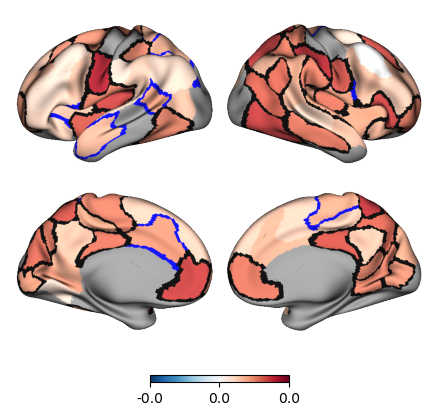

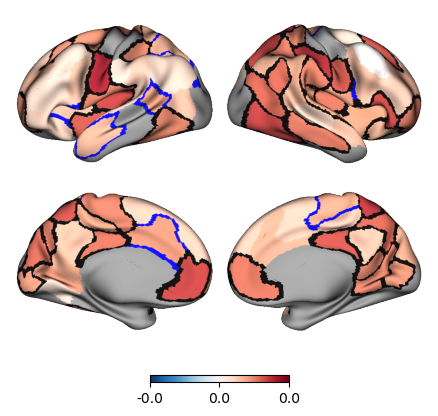

In [8]:
### want to basically plot the effect in this analysis only in the regions that show effects in the above! 
bad_ROIs = [30, 31, 32, 78, 79]
selected_nodes_list = [int(val)-1 for val in selected_nodes['node'][:-2]] #removing the hippocampus from this, will plot it below! 

vals = []
for node in range(100):
    if node in selected_nodes_list and node not in bad_ROIs:
        vals.append(all_sub['estimate'][node])
    else:
        vals.append(np.nan)
        
new_array = map_values_to_atlas(atlas_surf, np.array(vals))

translucent_map = make_translucent_map(new_array, np.nanmax(np.abs(new_array))*.20, new_array)
translucent_map 

p = Plot(lh, rh, views=['lateral', 'medial'])

p.add_layer(translucent_map , cbar=True, cmap='RdBu_r', color_range=(-.003, .003), zero_transparent=False)


selected_nodes_contours_plot = [int(val)-1 for val in selected_nodes_contours['node'][:-2]] #removing the hippocampus from this! 
selected_nodes_contours_plot_p = [int(val)-1 for val in selected_nodes_contours_p['node'][:-2]] #removing the hippocampus from this! 

for region in selected_nodes_contours_plot_p:
    if region in selected_nodes_list and region not in bad_ROIs:
        p_plot = [0] * 100
        p_plot[region] = 1  # Mark the current region
        p_array = map_values_to_atlas(atlas_surf, p_plot)

        # Add this region as a separate layer
        p.add_layer(p_array, cmap=blue_cmap, as_outline=True, cbar=False, outline_thickness=2)


for region in selected_nodes_contours_plot:
    if region in selected_nodes_list and region not in bad_ROIs:
        p_plot = [0] * 100
        p_plot[region] = 1  # Mark the current region
        p_array = map_values_to_atlas(atlas_surf, p_plot)

        # Add this region as a separate layer
        p.add_layer(p_array, cmap=black_cmap, as_outline=True, cbar=False, outline_thickness=2)



a = p.build()
fig = p.build() 
fig.savefig('../../plots/Fig3._characters/01._character_rep_cortical_fig.png', dpi=300)


/Users/f004p59/miniconda3/envs/brainiak_py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Image data has type int64, which may cause incompatibilities with other tools. This will error in NiBabel 5.0. This warning can be silenced by passing the dtype argument to Nifti1Image().
/Users/f004p59/miniconda3/envs/brainiak_py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Image data has type int64, which may cause incompatibilities with other tools. This will error in NiBabel 5.0. This warning can be silenced by passing the dtype argument to Nifti1Image().


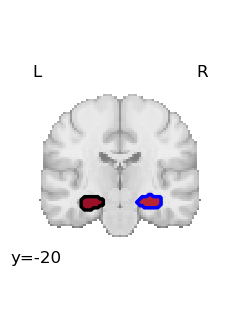

In [10]:

atlas_name = 'sub-maxprob-thr0-2mm'
harvard_oxford = datasets.fetch_atlas_harvard_oxford(atlas_name)

atlas = harvard_oxford.maps

hippocampus_indices = [9, 19]
hippocampus_indices = [9, 19]  


hippocampus_mask_L = (atlas.get_fdata() == hippocampus_indices[0]).astype(int)
hippocampus_mask_R = (atlas.get_fdata() == hippocampus_indices[1]).astype(int)

# Combine masks into one
combined_mask = np.zeros(atlas.shape)
combined_mask[hippocampus_mask_L == 1] = list(all_sub[all_sub['node']=='hippocampus_L']['estimate'])[0]
combined_mask[hippocampus_mask_R == 1] = list(all_sub[all_sub['node']=='hippocampus_R']['estimate'])[0]

# Create a new Nifti image for the combined mask
combined_img = nib.Nifti1Image(combined_mask, atlas.affine)
combined_mask[hippocampus_mask_L == 1] = list(all_sub[all_sub['node']=='hippocampus_L']['estimate'])[0]
combined_mask[hippocampus_mask_R == 1] = list(all_sub[all_sub['node']=='hippocampus_R']['estimate'])[0]

combined_img = nib.Nifti1Image(combined_mask, atlas.affine)
display = plotting.plot_stat_map(combined_img, display_mode='y', cut_coords=[-20], colorbar=False, cmap='RdBu_r',vmax=.003)

display.add_contours(nib.Nifti1Image(hippocampus_mask_R, atlas.affine), levels=[0.5], colors='blue', linewidths=2.5)
display.add_contours(nib.Nifti1Image(hippocampus_mask_L, atlas.affine), levels=[0.5], colors='black', linewidths=2.5)


display.savefig('../../plots/Fig3._characters/02._template_fig_hippocampus.png', dpi=300)

plotting.show()